In [1]:
# ---------------------------------------------------
# 0 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)


raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"

try:
    csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))
    if not csv_files:
        raise FileNotFoundError("csv_files list is empty – check the 'raw_dir' path.")
except FileNotFoundError as e:
    print(e)
    # As a fallback for demonstration, create a dummy dataframe
    print("Creating a sample DataFrame for demonstration purposes.")
    df = pd.DataFrame({
        'age': np.random.randint(0, 100, 5000),
        'modality': np.random.choice([
            'Computerized axial tomography (procedure)', 'Magnetic resonance imaging (procedure)', 'Endoscopy (procedure)',
            'Plain radiography (procedure)', 'Diagnostic ultrasonography (procedure)', 'Fluoroscopy (procedure)'
        ], size=5000),
        'patient_source': np.random.choice(['accident & emergency department', 'gp direct access service', 'inpatient', 'outpatient', 'elective admission'], size=5000),
        'cancer_flag': np.random.choice([True, False], size=5000, p=[0.1, 0.9]) # Add cancer_flag for demo
    })
else:
    print(f"Detected {len(csv_files)} files to load.")
    expected_cols = [
        'icb_code','icb_name','lsoa_code','nhs_region', 'site_code','site_name','provider_code','provider_name',
        'activity_month','financial_year','financial_month','test_date', 'age','sex','modality','sub_modality','procedure_name',
        'referral_type','patient_source','cancer_flag','subcancer_flag', 'referring_org_code','referring_org_name'
    ]
    dfs, meta = [], []
    for fp in csv_files:
        try:
            peek = pd.read_csv(fp, nrows=5)
            if not set(expected_cols).issubset(peek.columns):
                df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
            else:
                df_tmp = pd.read_csv(fp, low_memory=False)
            df_tmp = df_tmp.dropna(axis=1, how='all')
            df_tmp.columns = df_tmp.columns.str.strip().str.lower()
            df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
            for col in (set(expected_cols) - set(df_tmp.columns)):
                df_tmp[col] = pd.NA
            df_tmp = df_tmp[expected_cols]
            dfs.append(df_tmp)
            meta.append({
                "file": os.path.basename(fp), "rows": len(df_tmp),
                "cols": df_tmp.shape[1], "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
            })
        except Exception as e:
            print(f"Error loading file {os.path.basename(fp)}: {e}")
    meta_df = pd.DataFrame(meta)
    display(meta_df.style.set_caption("Loaded files – rows / cols / size"))
    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        print(f"\nCombined shape: {df.shape}")
    else:
        df = pd.DataFrame(columns=expected_cols)

Detected 7 files to load.


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000



Combined shape: (3989252, 23)


In [2]:
# -----------------------------------------------------------------
# ==> DIAGNOSTIC STEP: Explore Cancer & Sub-Cancer Flag columns <==
# -----------------------------------------------------------------

if 'df' in locals() and not df.empty:
    print("--- Exploring 'cancer_flag' ---")
    print("Data Type:", df['cancer_flag'].dtype)
    print("\nValue Counts (including missing values):")
    display(df['cancer_flag'].value_counts(dropna=False))

    print("\n\n--- Exploring 'subcancer_flag' ---")
    print("Data Type:", df['subcancer_flag'].dtype)
    print("\nValue Counts (including missing values):")
    display(df['subcancer_flag'].value_counts(dropna=False))

    print("\n\n--- Crosstab: cancer_flag vs. subcancer_flag ---")
    # This shows how the two flags relate to each other
    try:
        crosstab_df = pd.crosstab(df['cancer_flag'], df['subcancer_flag'], dropna=False)
        display(crosstab_df)
    except Exception as e:
        print(f"Could not create crosstab, likely due to data type issues: {e}")


    print("\n\n--- Sample rows where 'cancer_flag' is not null/false ---")
    # This helps us see what the actual text/values look like
    try:
        # Create a boolean mask that handles different "false" values
        is_not_false = ~df['cancer_flag'].astype(str).str.lower().isin(['false', '0', 'nan', ''])
        sample_cancer_rows = df[df['cancer_flag'].notna() & is_not_false].head(10)
        display(sample_cancer_rows[['cancer_flag', 'subcancer_flag', 'modality', 'procedure_name']])
    except Exception as e:
        print(f"Could not display sample rows: {e}")

else:
    print("DataFrame 'df' not found or is empty.")

--- Exploring 'cancer_flag' ---
Data Type: object

Value Counts (including missing values):


cancer_flag
NaN                                           3020026
Suspected Lung Cancer - Chest X-ray            684998
Suspected Ovarian Cancer                       104188
Suspected Brain Cancer                          77415
Suspected Lung Cancer - Chest + Abdomen CT      69806
Suspected Kidney or Bladder Cancer              16254
Suspected Oesophago-gastric Cancer               8349
Suspected Bowel Cancer                           8216
Name: count, dtype: int64



--- Exploring 'subcancer_flag' ---
Data Type: object

Value Counts (including missing values):


subcancer_flag
NaN                                       3020026
XR Chest                                   684998
US Abdomen                                  81955
MRI Head                                    58217
CT Thorax                                   34925
MRI Head with contrast                      19198
US Kidney                                   15963
CT Chest high resolution with contrast      15171
US Upper abdomen                            10729
CT Chest high resolution                    10418
US Abdomen and pelvis                        9216
CT Thorax and abdomen with contrast          8147
CT Colonoscopy virtual                       7290
Barium swallow                               6832
US Lower abdomen                             2288
CT Thorax and abdomen                        1145
Gastroscopy                                   951
Colonoscopy                                   863
Barium meal (with/without swallow)            564
US Urinary bladder                 



--- Crosstab: cancer_flag vs. subcancer_flag ---


subcancer_flag,Barium meal (with/without swallow),Barium swallow,CT Chest high resolution,CT Chest high resolution with contrast,CT Colonoscopy virtual,CT Thorax,CT Thorax and abdomen,CT Thorax and abdomen with contrast,Colonoscopy,Flexible fibreoptic sigmoidoscopy,Gastroscopy,MRI Head,MRI Head with contrast,US Abdomen,US Abdomen and pelvis,US Doppler renal,US Kidney,US Lower abdomen,US Upper abdomen,US Urinary bladder,Upper GI endoscopy,XR Chest,NaN
cancer_flag,,,,,,,,,,,,,,,,,,,,,,,
Suspected Bowel Cancer,0,0,0,0,7290,0,0,0,863,63,0,0,0,0,0,0,0,0,0,0,0,0,0
Suspected Brain Cancer,0,0,0,0,0,0,0,0,0,0,0,58217,19198,0,0,0,0,0,0,0,0,0,0
Suspected Kidney or Bladder Cancer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,15963,0,0,152,0,0,0
Suspected Lung Cancer - Chest + Abdomen CT,0,0,10418,15171,0,34925,1145,8147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Suspected Lung Cancer - Chest X-ray,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,684998,0
Suspected Oesophago-gastric Cancer,564,6832,0,0,0,0,0,0,0,0,951,0,0,0,0,0,0,0,0,0,2,0,0
Suspected Ovarian Cancer,0,0,0,0,0,0,0,0,0,0,0,0,0,81955,9216,0,0,2288,10729,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3020026




--- Sample rows where 'cancer_flag' is not null/false ---


,cancer_flag,subcancer_flag,modality,procedure_name
0,Suspected Ovarian Cancer,US Upper abdomen,Diagnostic ultrasonography (procedure),Ultrasound scan of upper abdomen (procedure)
2,Suspected Lung Cancer - Chest X-ray,XR Chest,Plain radiography (procedure),Plain chest X-ray (procedure) (399208008)
10,Suspected Lung Cancer - Chest X-ray,XR Chest,Plain radiography (procedure),Plain chest X-ray (procedure) (399208008)
14,Suspected Lung Cancer - Chest X-ray,XR Chest,Plain radiography (procedure),Plain chest X-ray (procedure) (399208008)
20,Suspected Lung Cancer - Chest X-ray,XR Chest,Plain radiography (procedure),Plain chest X-ray (procedure) (399208008)
26,Suspected Lung Cancer - Chest X-ray,XR Chest,Plain radiography (procedure),Plain chest X-ray (procedure) (399208008)
29,Suspected Brain Cancer,MRI Head,Magnetic resonance imaging (procedure),Magnetic resonance imaging of head (procedure)
45,Suspected Brain Cancer,MRI Head,Magnetic resonance imaging (procedure),Magnetic resonance imaging of head (procedure)...
50,Suspected Bowel Cancer,CT Colonoscopy virtual,Computerized axial tomography (procedure),Virtual computed tomography colonoscopy (proce...
67,Suspected Lung Cancer - Chest X-ray,XR Chest,Plain radiography (procedure),Plain chest X-ray (procedure)


In [3]:
# --- Basic type coercion and cleaning ---
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .replace({"nan": np.nan}).fillna("unknown")
)

# --- Create 'ps_bucket' (Patient Source Bucket) ---
ps_bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency", r"gp direct|gp ": "GP",
    r"inpatient": "Inpatient", r"outpatient": "Outpatient", r"elective|planned": "Elective",
}
def ps_bucket(txt: str) -> str:
    for pat, lab in ps_bucket_map.items():
        if re.search(pat, txt, re.IGNORECASE): return lab
    return "Other/Unknown"
df["ps_bucket"] = df["patient_source"].apply(ps_bucket)

# --- Create 'modality_bucket' ---
modality_bucket_map = {
    r"tomography|ct": "CT", r"magnetic resonance|mri": "MRI", r"endoscopy": "Endoscopy",
    r"radiography": "Radiography", r"ultrasonography|ultrasound": "Ultrasound", r"fluoroscopy": "Fluoroscopy"
}
def modality_bucket(txt: str) -> str:
    txt = str(txt).lower()
    for pat, lab in modality_bucket_map.items():
        if re.search(pat, txt): return lab
    return "Other"
df["modality_bucket"] = df["modality"].apply(modality_bucket)


# =====================================================================
#  ==> CORRECTED LOGIC: Standardize 'cancer_flag' into 'cancer_status' <==
# =====================================================================
# If 'cancer_flag' has any text in it, it's a cancer pathway.
# If it's empty (NaN), it's a non-cancer pathway.
df['cancer_status'] = np.where(df['cancer_flag'].notna(), 'Cancer Pathway', 'Non-Cancer Pathway')

print("\nCancer Status Distribution:")
print(df['cancer_status'].value_counts(dropna=False))


# --- Create 'age_at_event' ---
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74", "75-79","80-84","85+"]
})
df.dropna(subset=['age'], inplace=True)
df = df[df["age"] % 1 == 0]
df["age"] = df["age"].astype(int)
df["age_at_event"] = pd.cut(df["age"], bins=(bands["lower"].tolist() + [np.inf]), labels=bands["label"], right=False)

# --- Create combined 'em'/'el' source ---
def assign_em_el_source(ps_bucket):
    if ps_bucket in ['Emergency', 'Inpatient']: return 'em (Emergency/Inpatient)'
    elif ps_bucket in ['GP', 'Outpatient', 'Elective']: return 'el (Elective/GP)'
    else: return 'Other/Unknown'
df['patient_source_combined'] = df['ps_bucket'].apply(assign_em_el_source)

print("\nFinal DataFrame Head:")
display(df[['age_at_event', 'ps_bucket', 'patient_source_combined', 'modality_bucket', 'cancer_flag', 'cancer_status']].head())


Cancer Status Distribution:
cancer_status
Non-Cancer Pathway    3020026
Cancer Pathway         969226
Name: count, dtype: int64

Final DataFrame Head:


,age_at_event,ps_bucket,patient_source_combined,modality_bucket,cancer_flag,cancer_status
0,55-59,GP,el (Elective/GP),Ultrasound,Suspected Ovarian Cancer,Cancer Pathway
1,70-74,Inpatient,em (Emergency/Inpatient),Radiography,NaN,Non-Cancer Pathway
2,65-69,GP,el (Elective/GP),Radiography,Suspected Lung Cancer - Chest X-ray,Cancer Pathway
3,70-74,Emergency,em (Emergency/Inpatient),Radiography,NaN,Non-Cancer Pathway
4,70-74,GP,el (Elective/GP),Other,NaN,Non-Cancer Pathway


In [4]:
def plot_usage_by_cancer_status(df, modality_bucket_name):
    """
    Generates side-by-side plots comparing Cancer vs. Non-Cancer pathways
    for a given modality bucket, using 'age' as the x-axis.
    """
    if df.empty or modality_bucket_name not in df['modality_bucket'].unique():
        print(f"No data for modality bucket '{modality_bucket_name}'. Skipping.")
        return

    print(f"--- Generating Comparison Plots for {modality_bucket_name} ---")

    # Filter data for the modality
    modality_df = df[df['modality_bucket'] == modality_bucket_name].copy()

    # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(3, 2, figsize=(18, 24), sharex=True)
    fig.suptitle(f'{modality_bucket_name} Usage by Age: Cancer Pathway vs. Non-Cancer Pathway', fontsize=20, y=1.02)
    
    status_types = ['Cancer Pathway', 'Non-Cancer Pathway']
    plot_titles = [
        'Split by Patient Source',
        'All Sources Combined',
        'Combined Emergency vs. Elective'
    ]

    for i, status in enumerate(status_types):
        # Filter for Cancer/Non-Cancer
        status_df = modality_df[modality_df['cancer_status'] == status]
        
        # --- Plot 1: Individual Patient Sources ---
        ax = axes[0, i]
        sns.lineplot(
            data=status_df, x='age', y=status_df.index, hue='ps_bucket',
            estimator='count', marker='o', errorbar=None, ax=ax
        )
        ax.set_title(f'{status}\n({plot_titles[0]})')
        ax.set_ylabel('Number of Procedures')
        ax.set_xlabel('Age (years)')
        ax.tick_params(axis='x', rotation=45)

        # --- Plot 2: All Sources Combined ---
        ax = axes[1, i]
        agg_all = status_df.groupby('age', as_index=False, observed=True).size()
        sns.lineplot(data=agg_all, x='age', y='size', marker='o', ax=ax)
        ax.set_title(f'{status}\n({plot_titles[1]})')
        ax.set_ylabel('Number of Procedures')
        ax.set_xlabel('Age (years)')
        ax.tick_params(axis='x', rotation=45)

        # --- Plot 3: Combined Emergency/Elective ---
        ax = axes[2, i]
        sns.lineplot(
            data=status_df, x='age', y=status_df.index, hue='patient_source_combined',
            estimator='count', marker='o', errorbar=None, ax=ax
        )
        ax.set_title(f'{status}\n({plot_titles[2]})')
        ax.set_ylabel('Number of Procedures')
        ax.set_xlabel('Age (years)')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


--- Generating Comparison Plots for CT ---


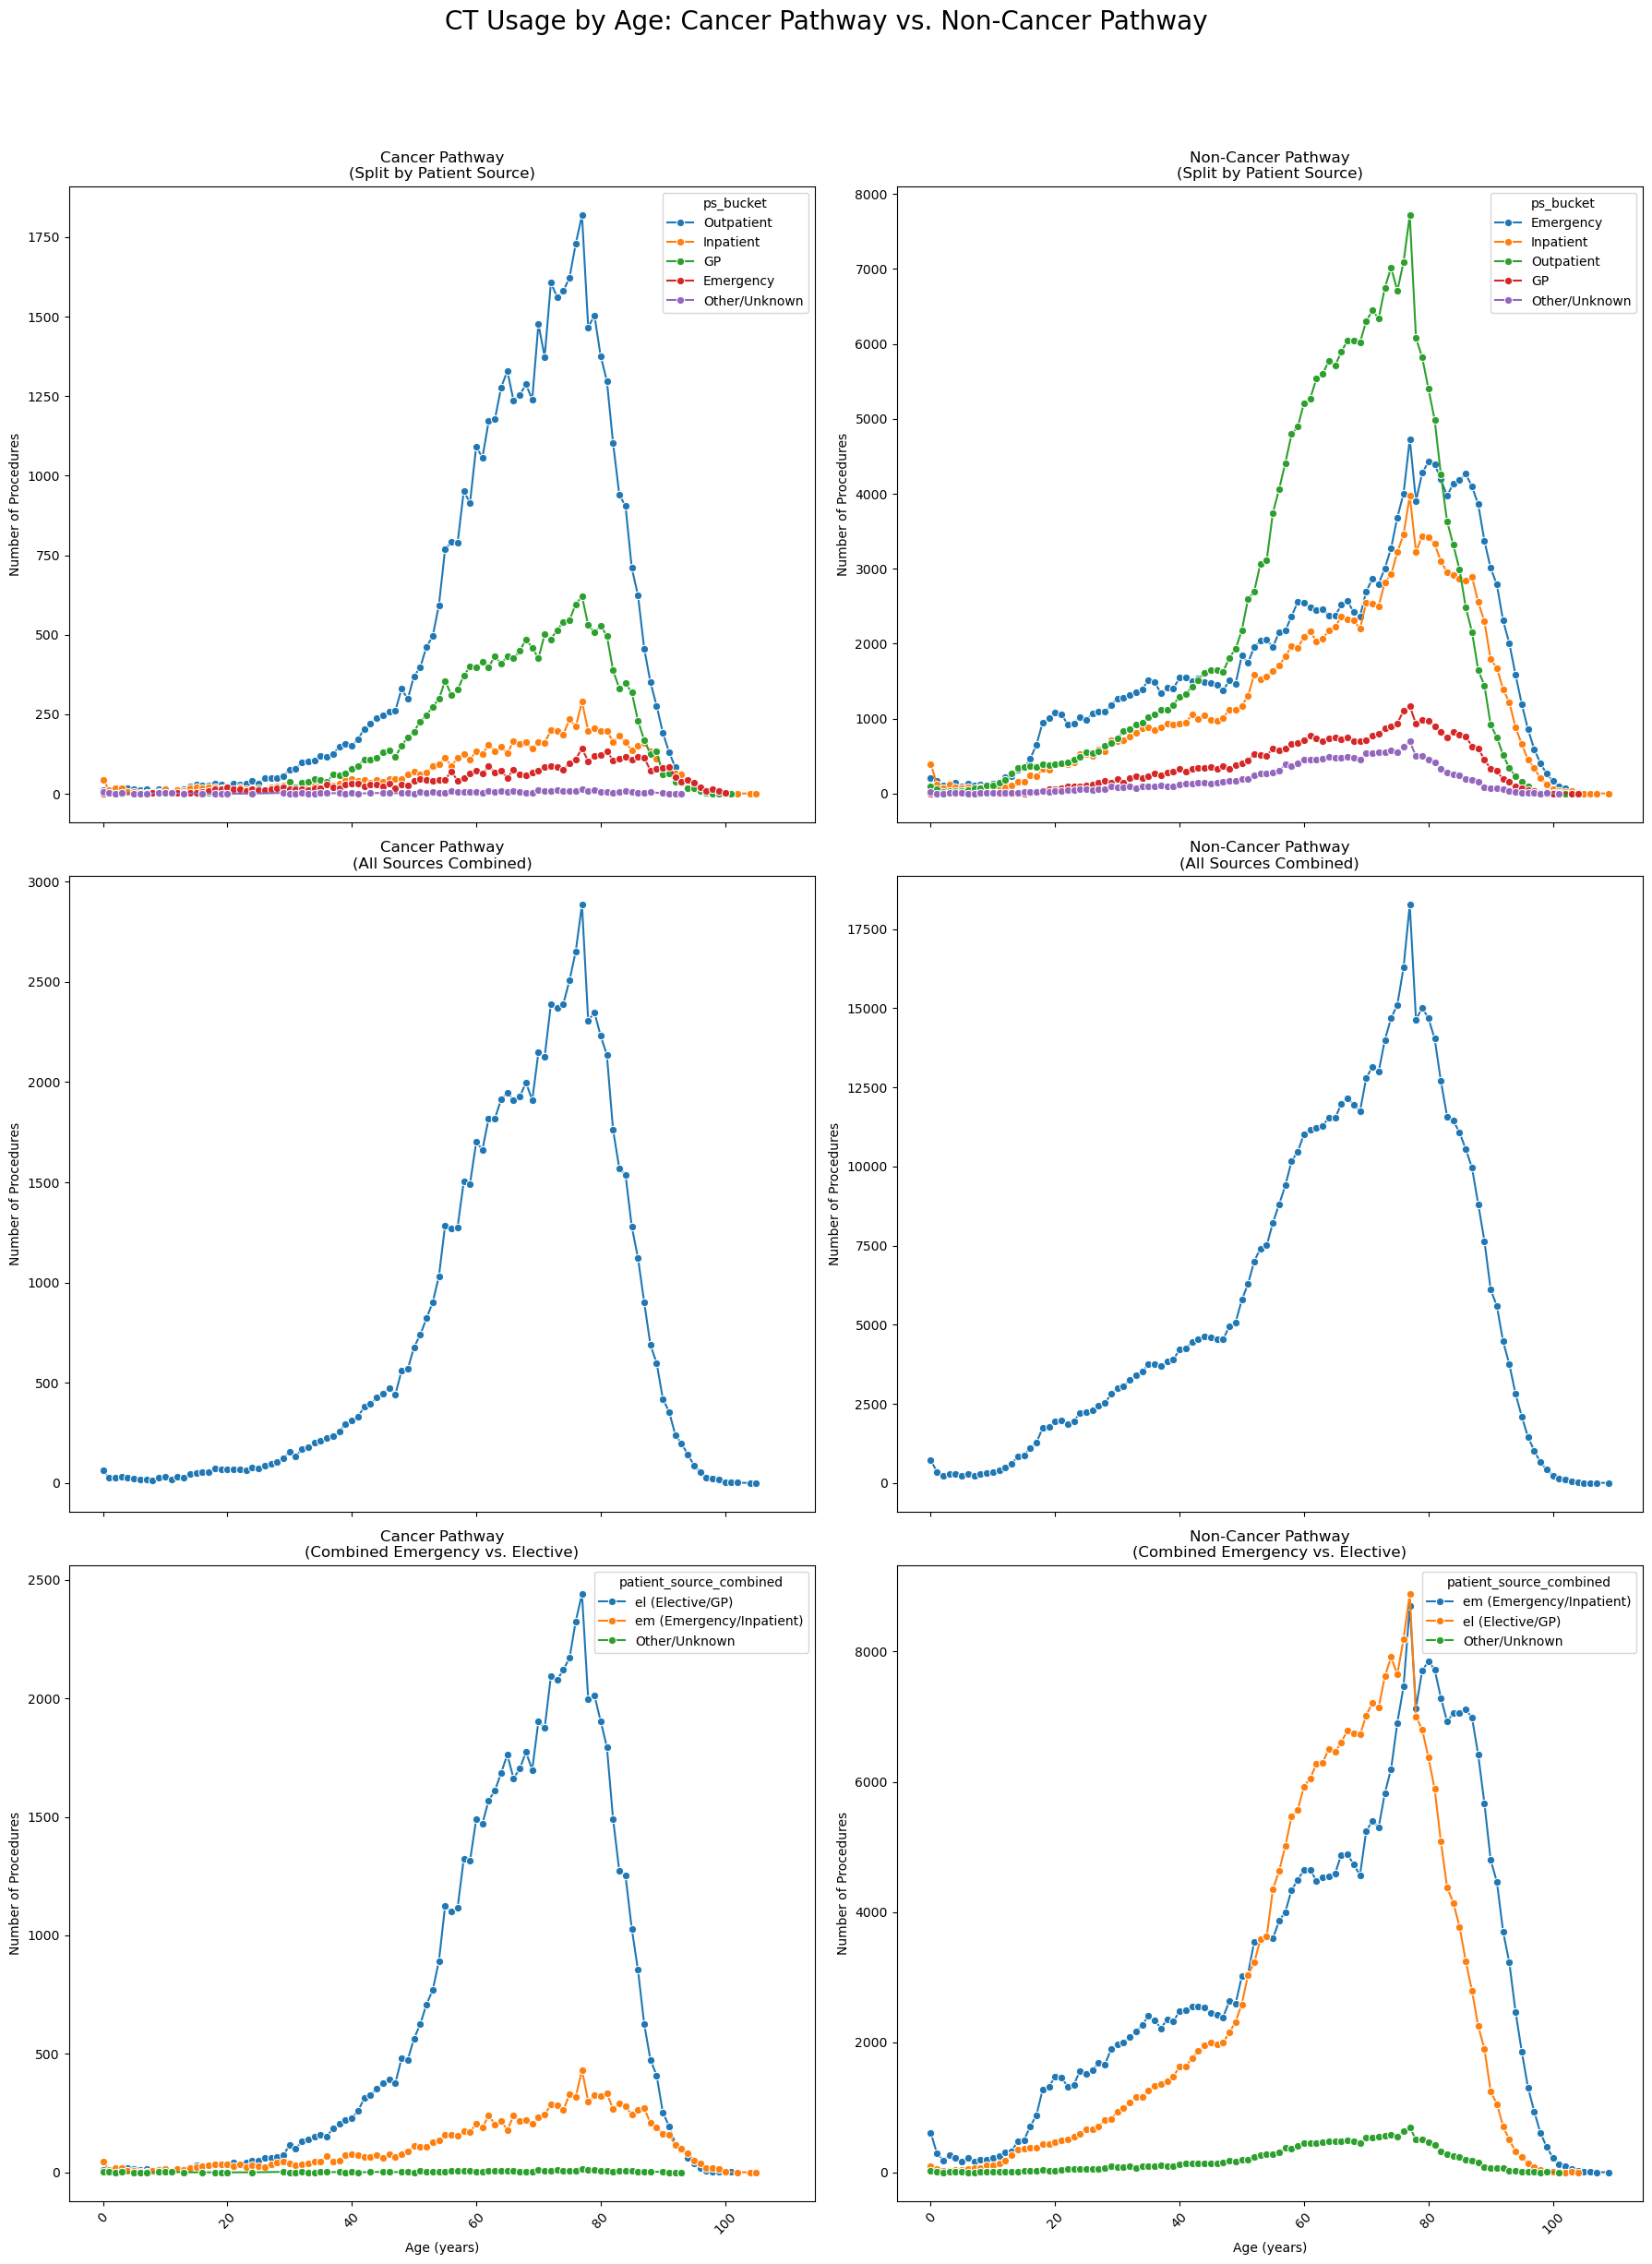

--- Generating Comparison Plots for MRI ---


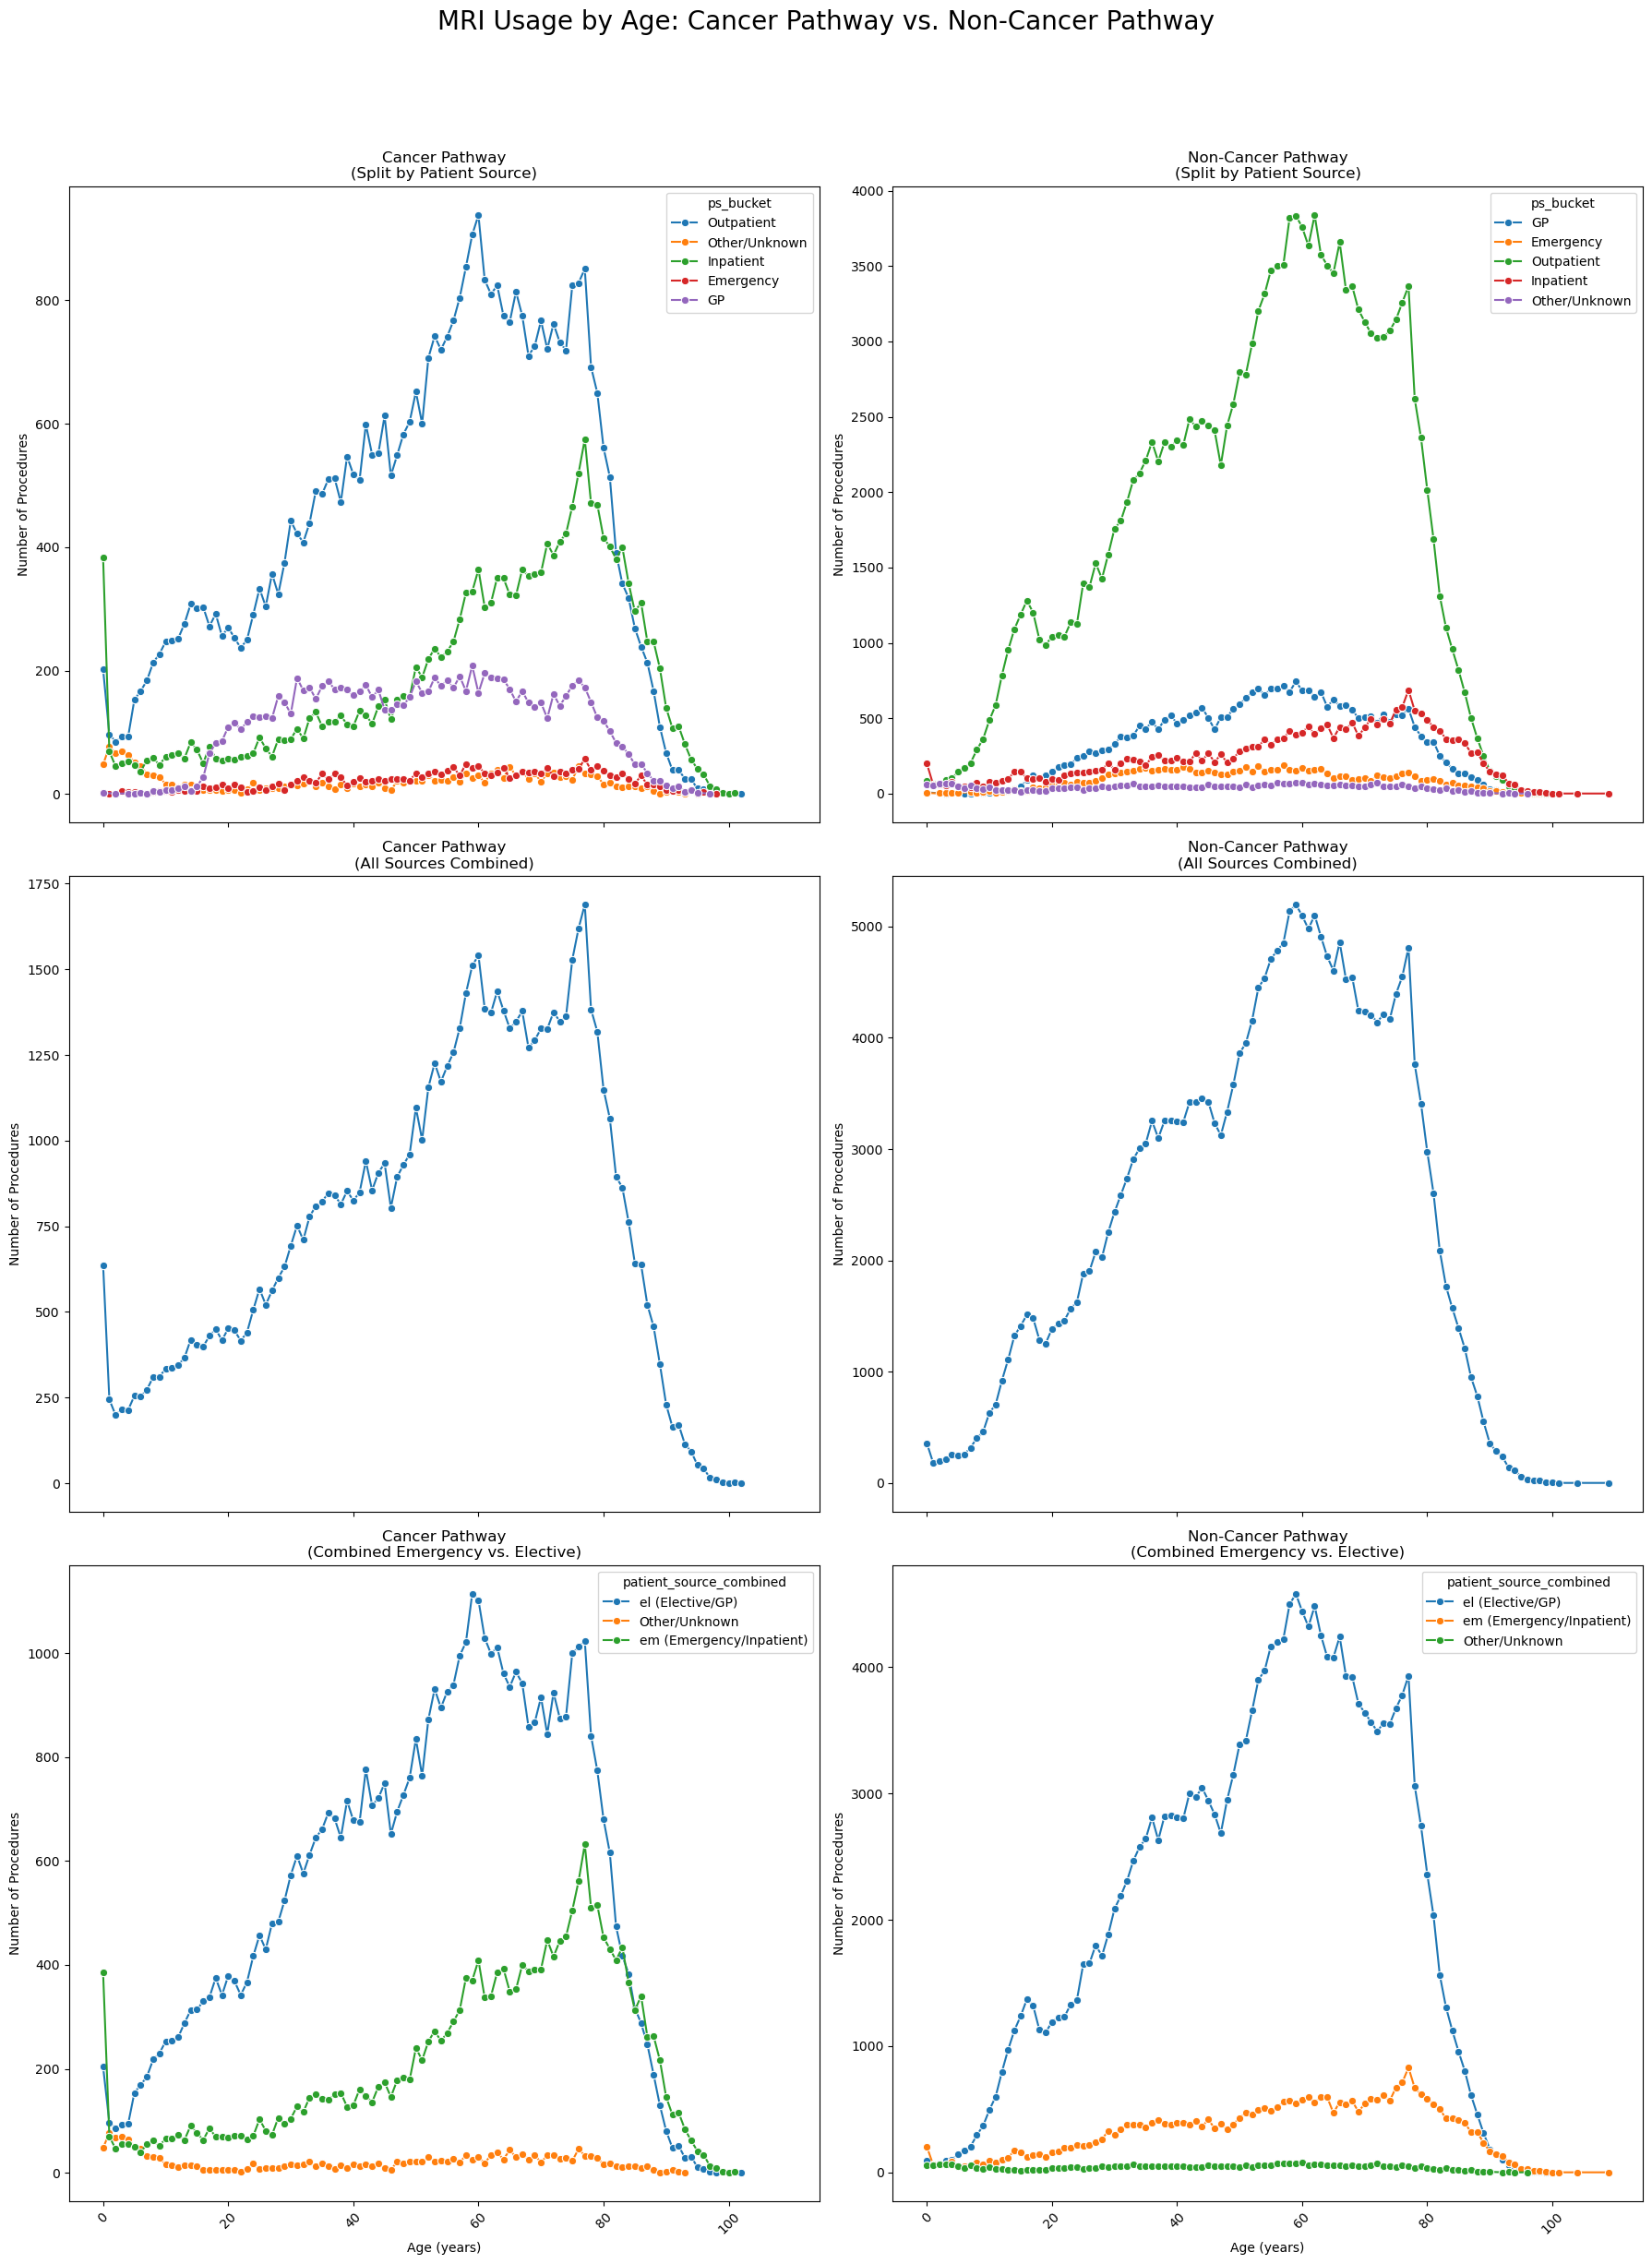

--- Generating Comparison Plots for Endoscopy ---


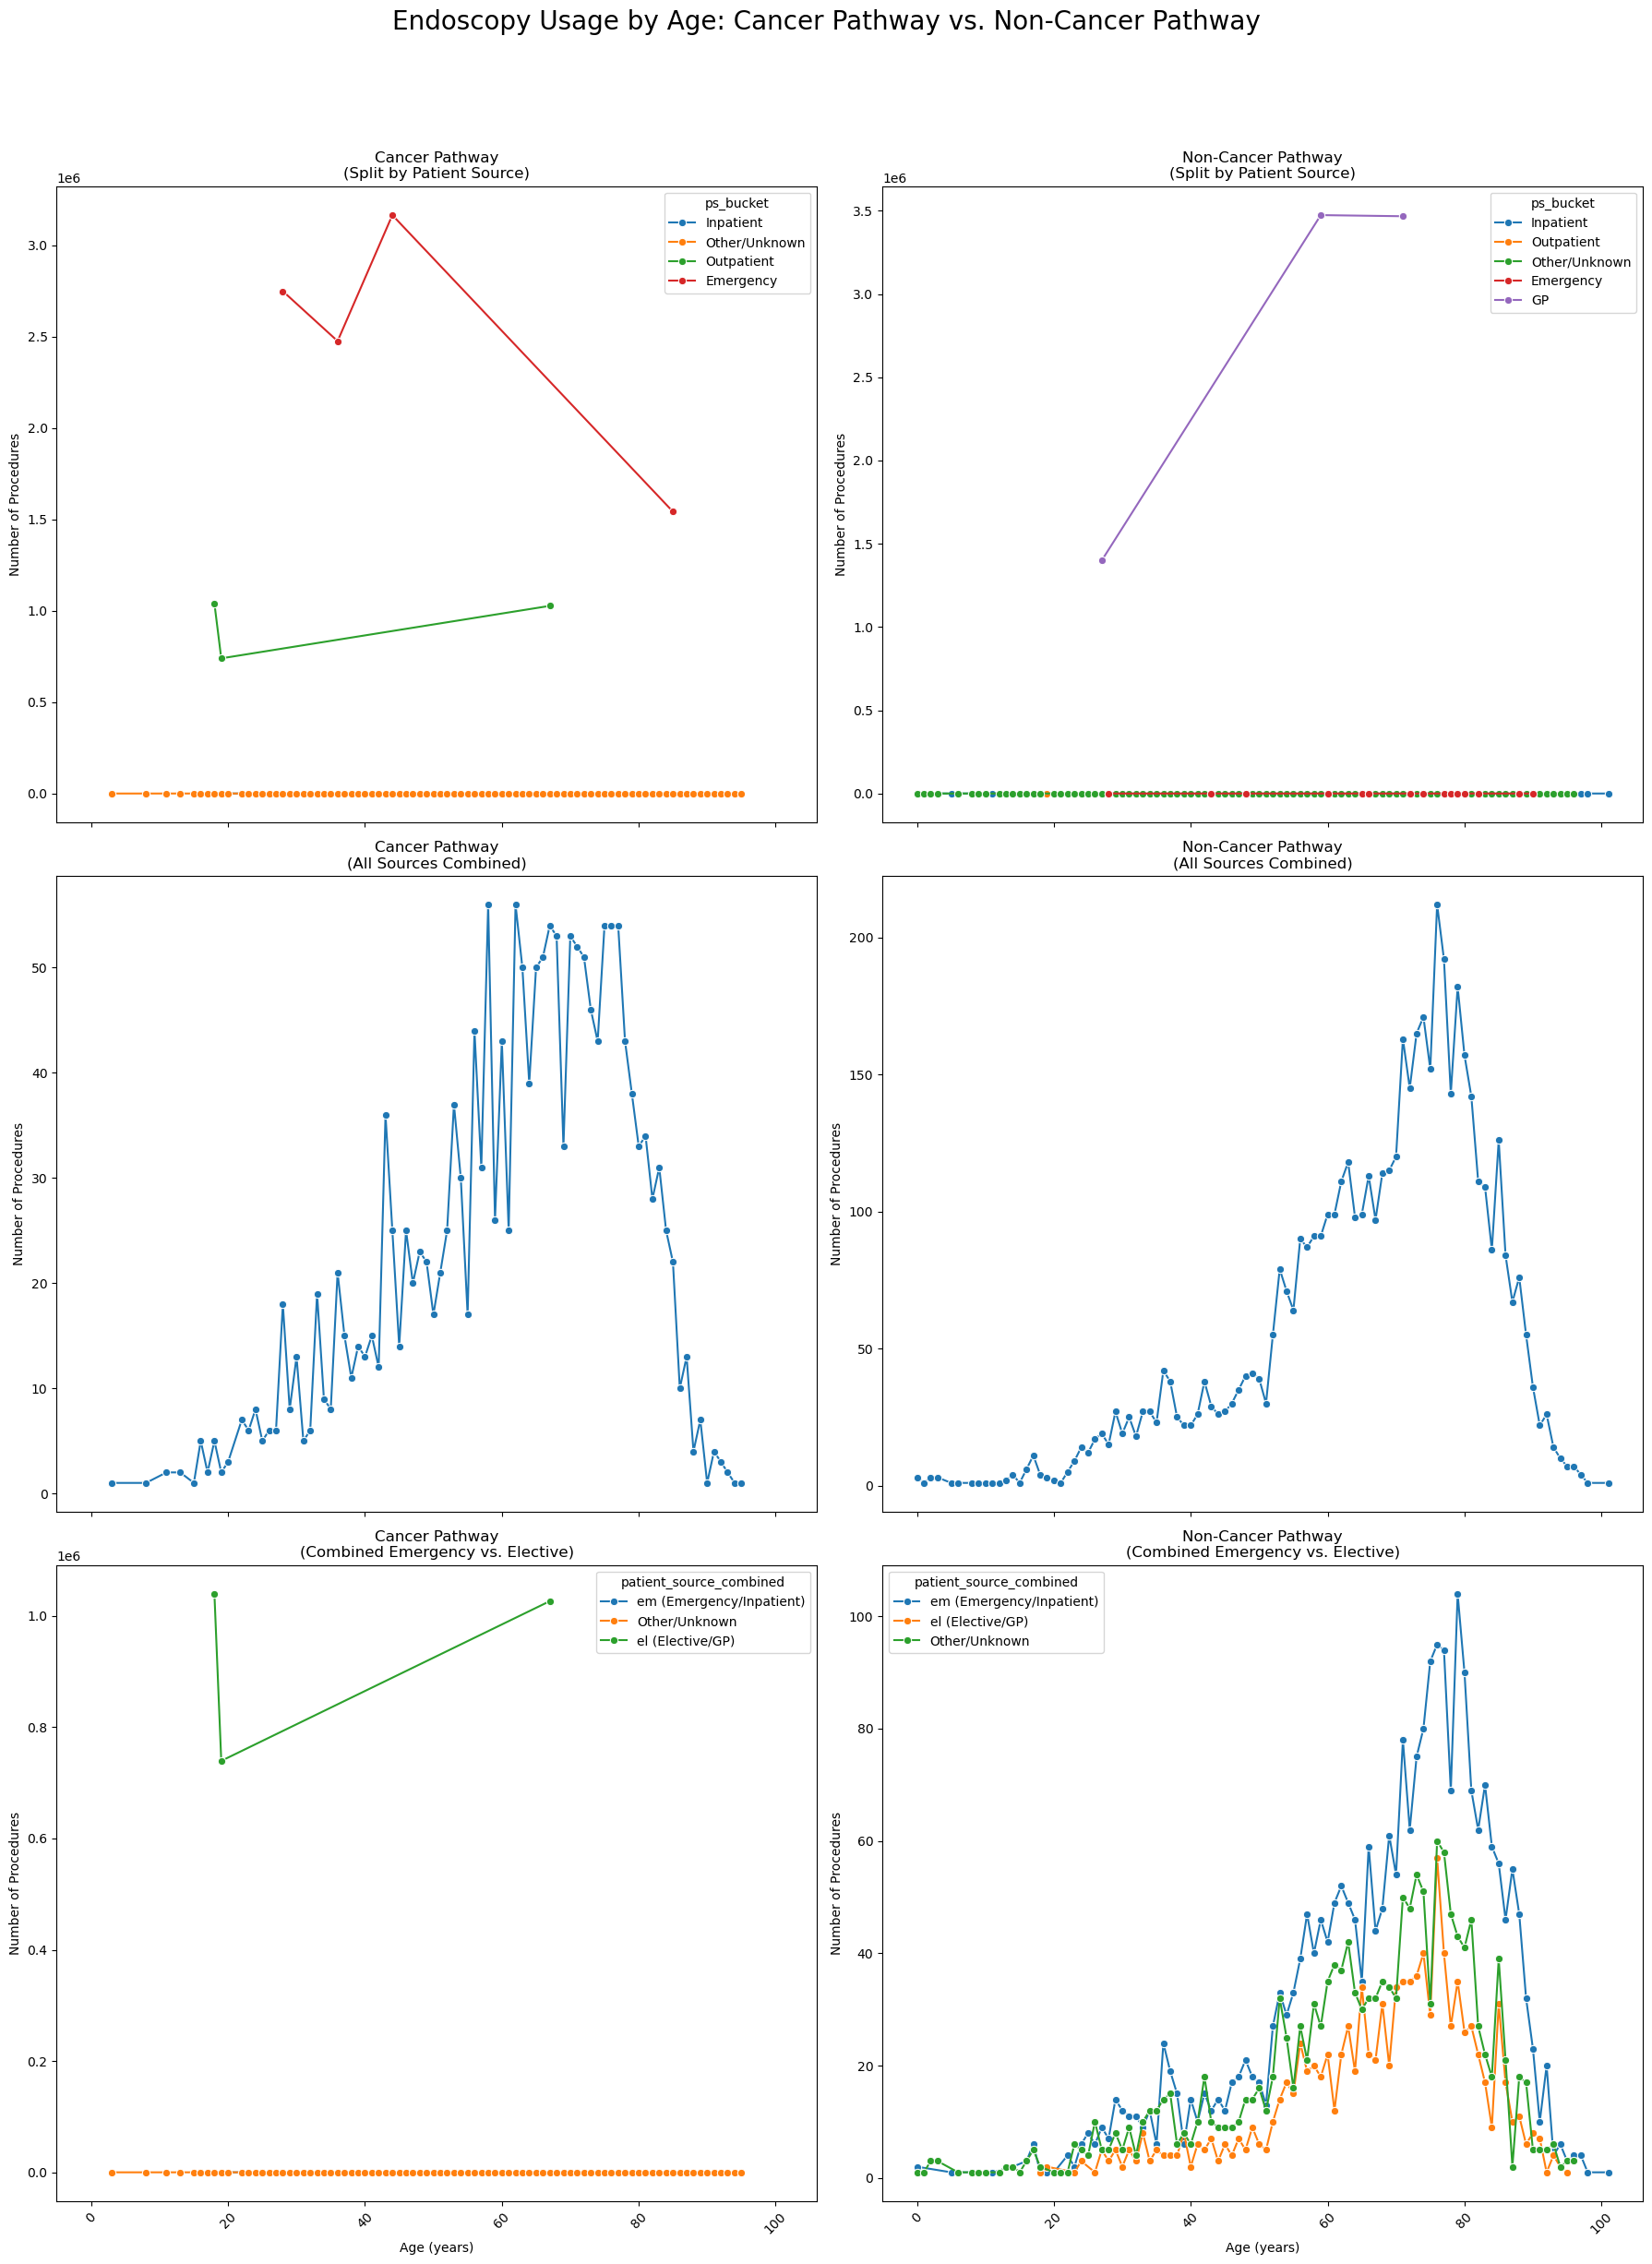

In [5]:
if 'df' in locals() and not df.empty:
    # Specify the main modality buckets you are interested in
    modality_buckets_to_plot = ['CT', 'MRI', 'Endoscopy']
    
    available_buckets = df['modality_bucket'].unique()
    
    for bucket in modality_buckets_to_plot:
        if bucket in available_buckets:
            plot_usage_by_cancer_status(df, bucket)
        else:
            print(f"Modality bucket '{bucket}' not found in the dataset.")
else:
    print("DataFrame 'df' is not available or is empty. Cannot generate plots.")

In [6]:
def plot_usage_by_cancer_status_synced(df, modality_bucket_name):
    """
    Generates side-by-side plots comparing Cancer vs. Non-Cancer pathways
    for a given modality bucket, ensuring y-axes are synchronized.
    Uses 'age' as the x-axis.
    """
    if df.empty or modality_bucket_name not in df['modality_bucket'].unique():
        print(f"No data for modality bucket '{modality_bucket_name}'. Skipping.")
        return

    print(f"--- Generating SYNCED Comparison Plots for {modality_bucket_name} ---")

    modality_df = df[df['modality_bucket'] == modality_bucket_name].copy()
    fig, axes = plt.subplots(3, 2, figsize=(18, 24), sharex=True)
    fig.suptitle(f'{modality_bucket_name} Usage (Synced Axes): Cancer vs. Non-Cancer Pathway', fontsize=20, y=1.02)

    status_types = ['Cancer Pathway', 'Non-Cancer Pathway']

    # --- Plot Row 1: Individual Patient Sources ---
    for i, status in enumerate(status_types):
        ax = axes[0, i]
        status_df = modality_df[modality_df['cancer_status'] == status]
        sns.lineplot(
            data=status_df, x='age', y=status_df.index, hue='ps_bucket',
            estimator='count', marker='o', errorbar=None, ax=ax
        )
        ax.set_title(f'{status}\n(Split by Patient Source)')
        ax.set_ylabel('Number of Procedures')
        ax.set_xlabel('Age (years)')
        if ax.get_legend():
            ax.get_legend().set_title('Patient Source')
    # Sync Y-axes for Row 1
    max_y1 = max(axes[0, 0].get_ylim()[1], axes[0, 1].get_ylim()[1])
    axes[0, 0].set_ylim(0, max_y1 * 1.05)
    axes[0, 1].set_ylim(0, max_y1 * 1.05)

    # --- Plot Row 2: All Sources Combined ---
    for i, status in enumerate(status_types):
        ax = axes[1, i]
        status_df = modality_df[modality_df['cancer_status'] == status]
        agg_all = status_df.groupby('age', as_index=False, observed=True).size()
        sns.lineplot(data=agg_all, x='age', y='size', marker='o', ax=ax)
        ax.set_title(f'{status}\n(All Sources Combined)')
        ax.set_ylabel('Number of Procedures')
        ax.set_xlabel('Age (years)')
    # Sync Y-axes for Row 2
    max_y2 = max(axes[1, 0].get_ylim()[1], axes[1, 1].get_ylim()[1])
    axes[1, 0].set_ylim(0, max_y2 * 1.05)
    axes[1, 1].set_ylim(0, max_y2 * 1.05)

    # --- Plot Row 3: Combined Emergency/Elective ---
    for i, status in enumerate(status_types):
        ax = axes[2, i]
        status_df = modality_df[modality_df['cancer_status'] == status]
        sns.lineplot(
            data=status_df, x='age', y=status_df.index, hue='patient_source_combined',
            estimator='count', marker='o', errorbar=None, ax=ax
        )
        ax.set_title(f'{status}\n(Combined Emergency vs. Elective)')
        ax.set_ylabel('Number of Procedures')
        ax.set_xlabel('Age (years)')
        if ax.get_legend():
            ax.get_legend().set_title('Combined Source')
    # Sync Y-axes for Row 3
    max_y3 = max(axes[2, 0].get_ylim()[1], axes[2, 1].get_ylim()[1])
    axes[2, 0].set_ylim(0, max_y3 * 1.05)
    axes[2, 1].set_ylim(0, max_y3 * 1.05)

    # Final layout adjustments
    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


--- Generating SYNCED Comparison Plots for CT ---


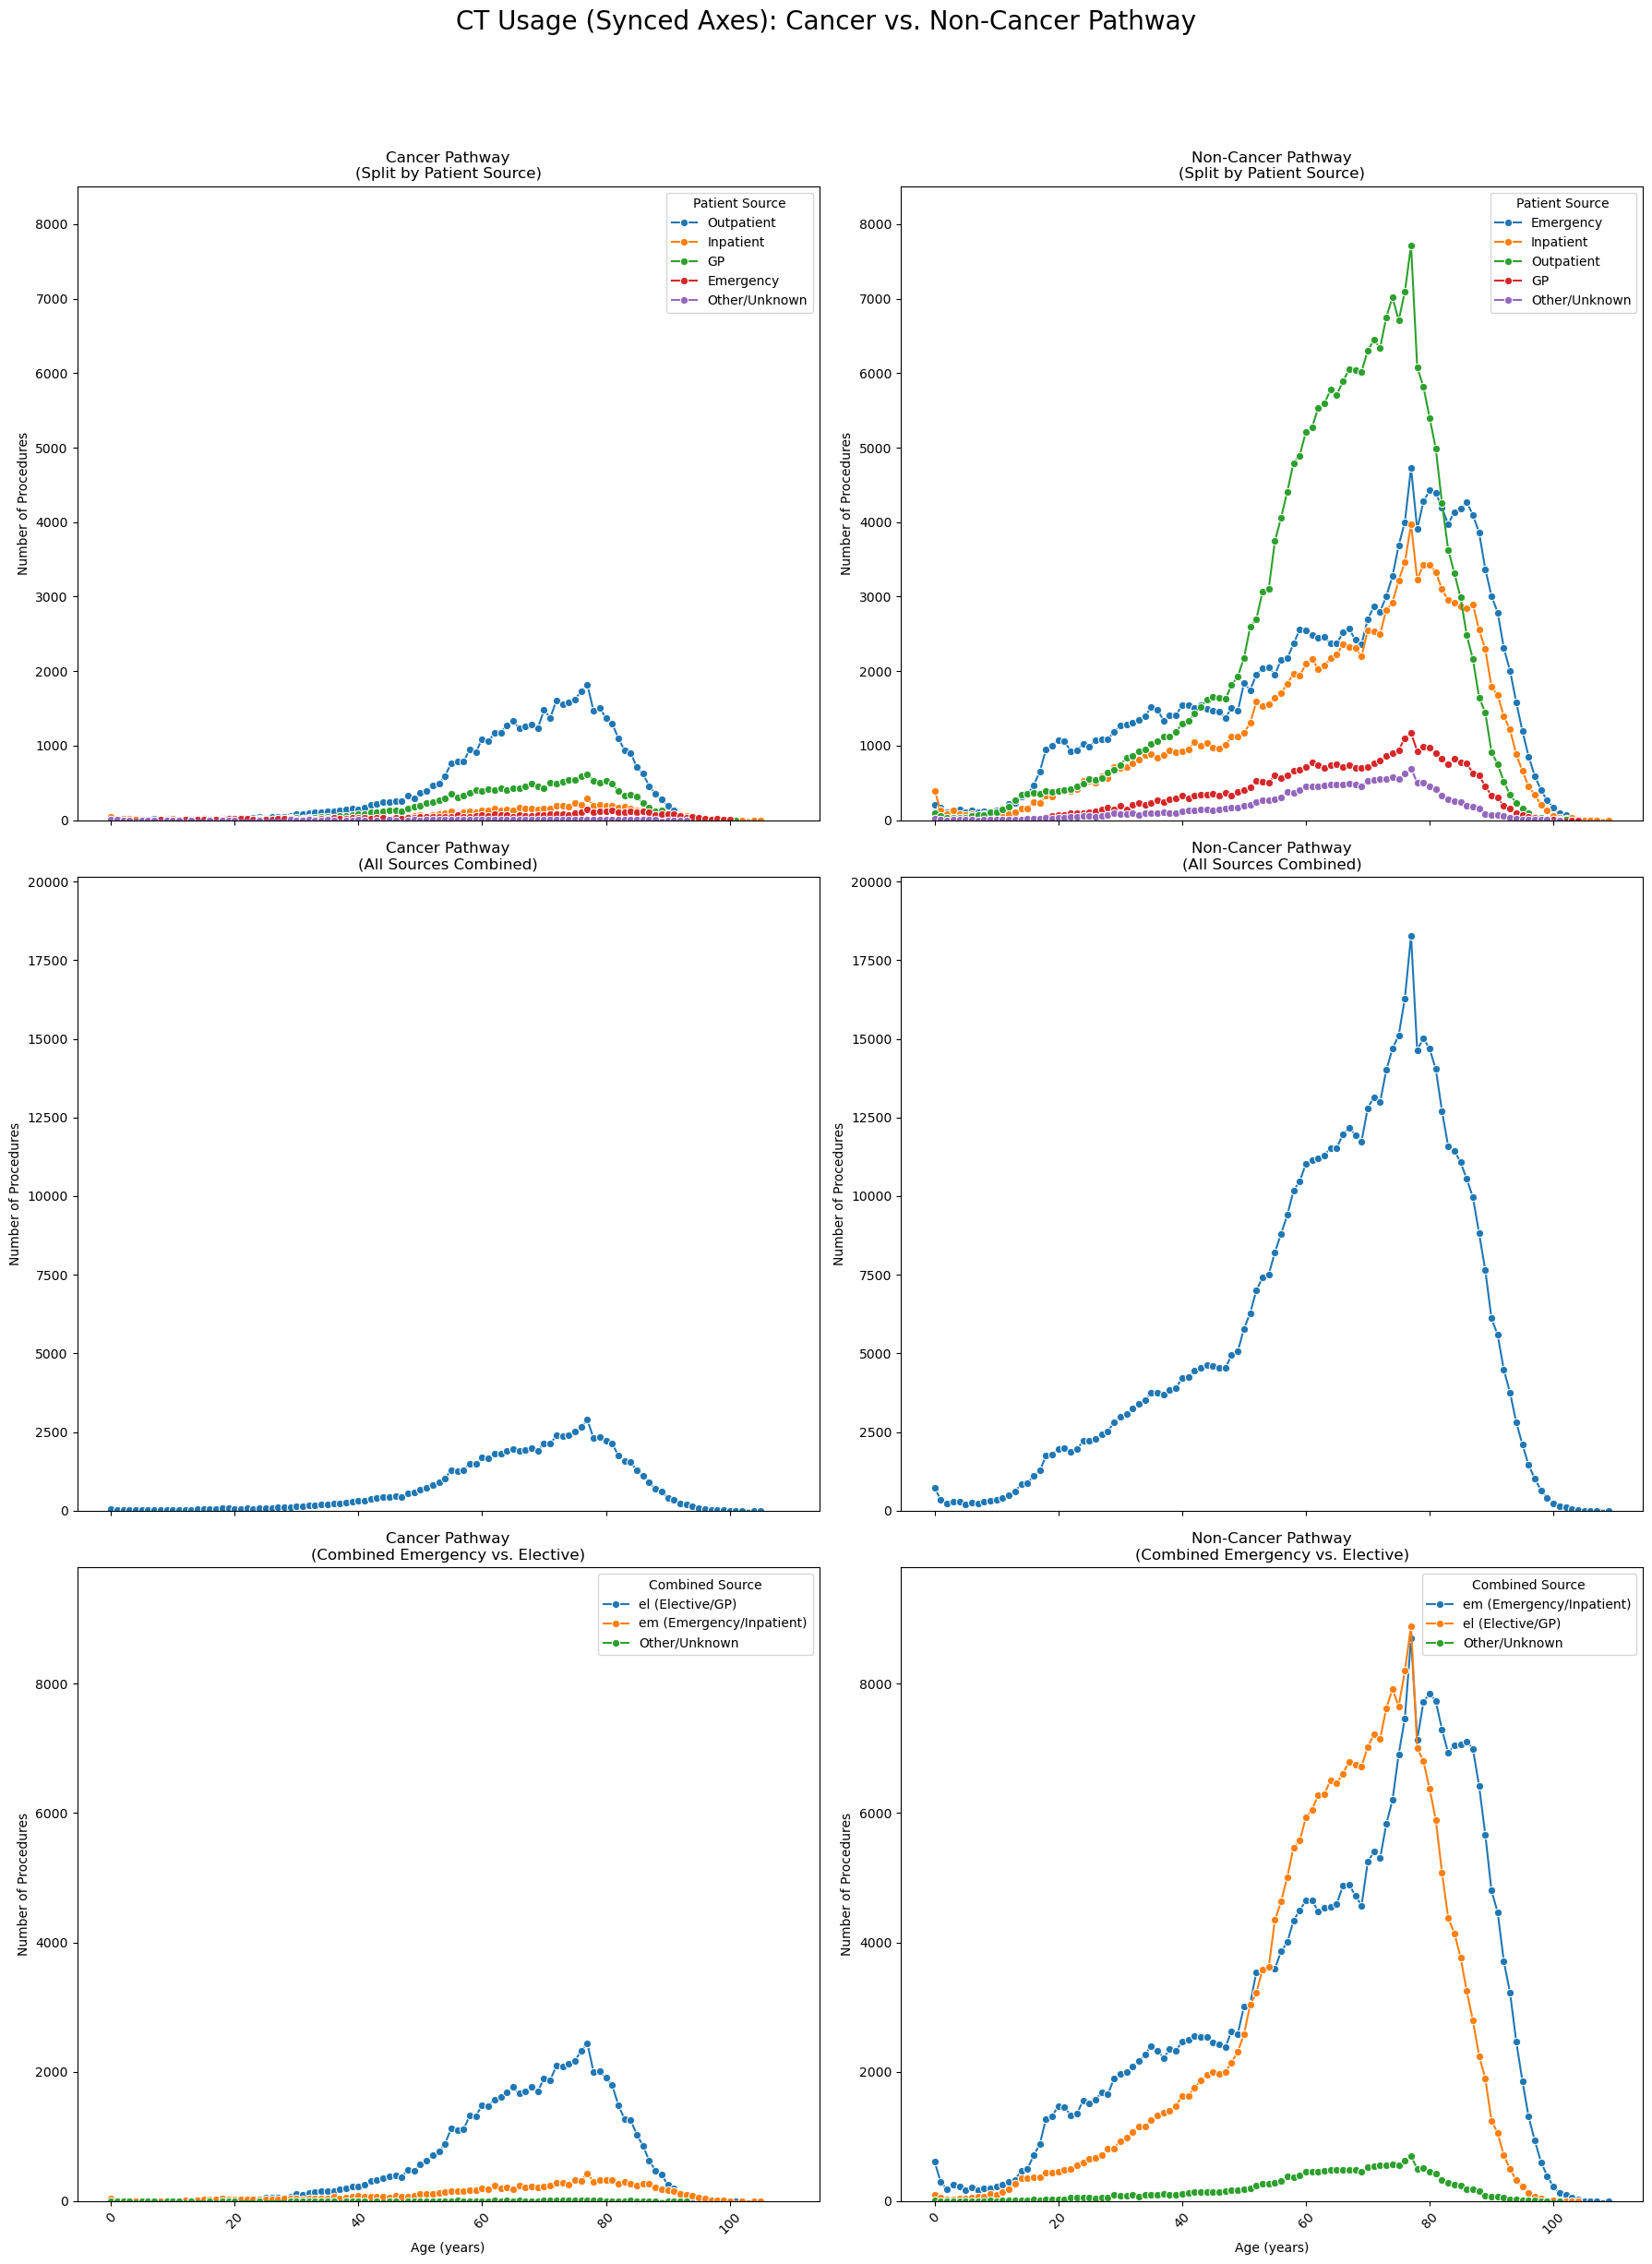

--- Generating SYNCED Comparison Plots for MRI ---


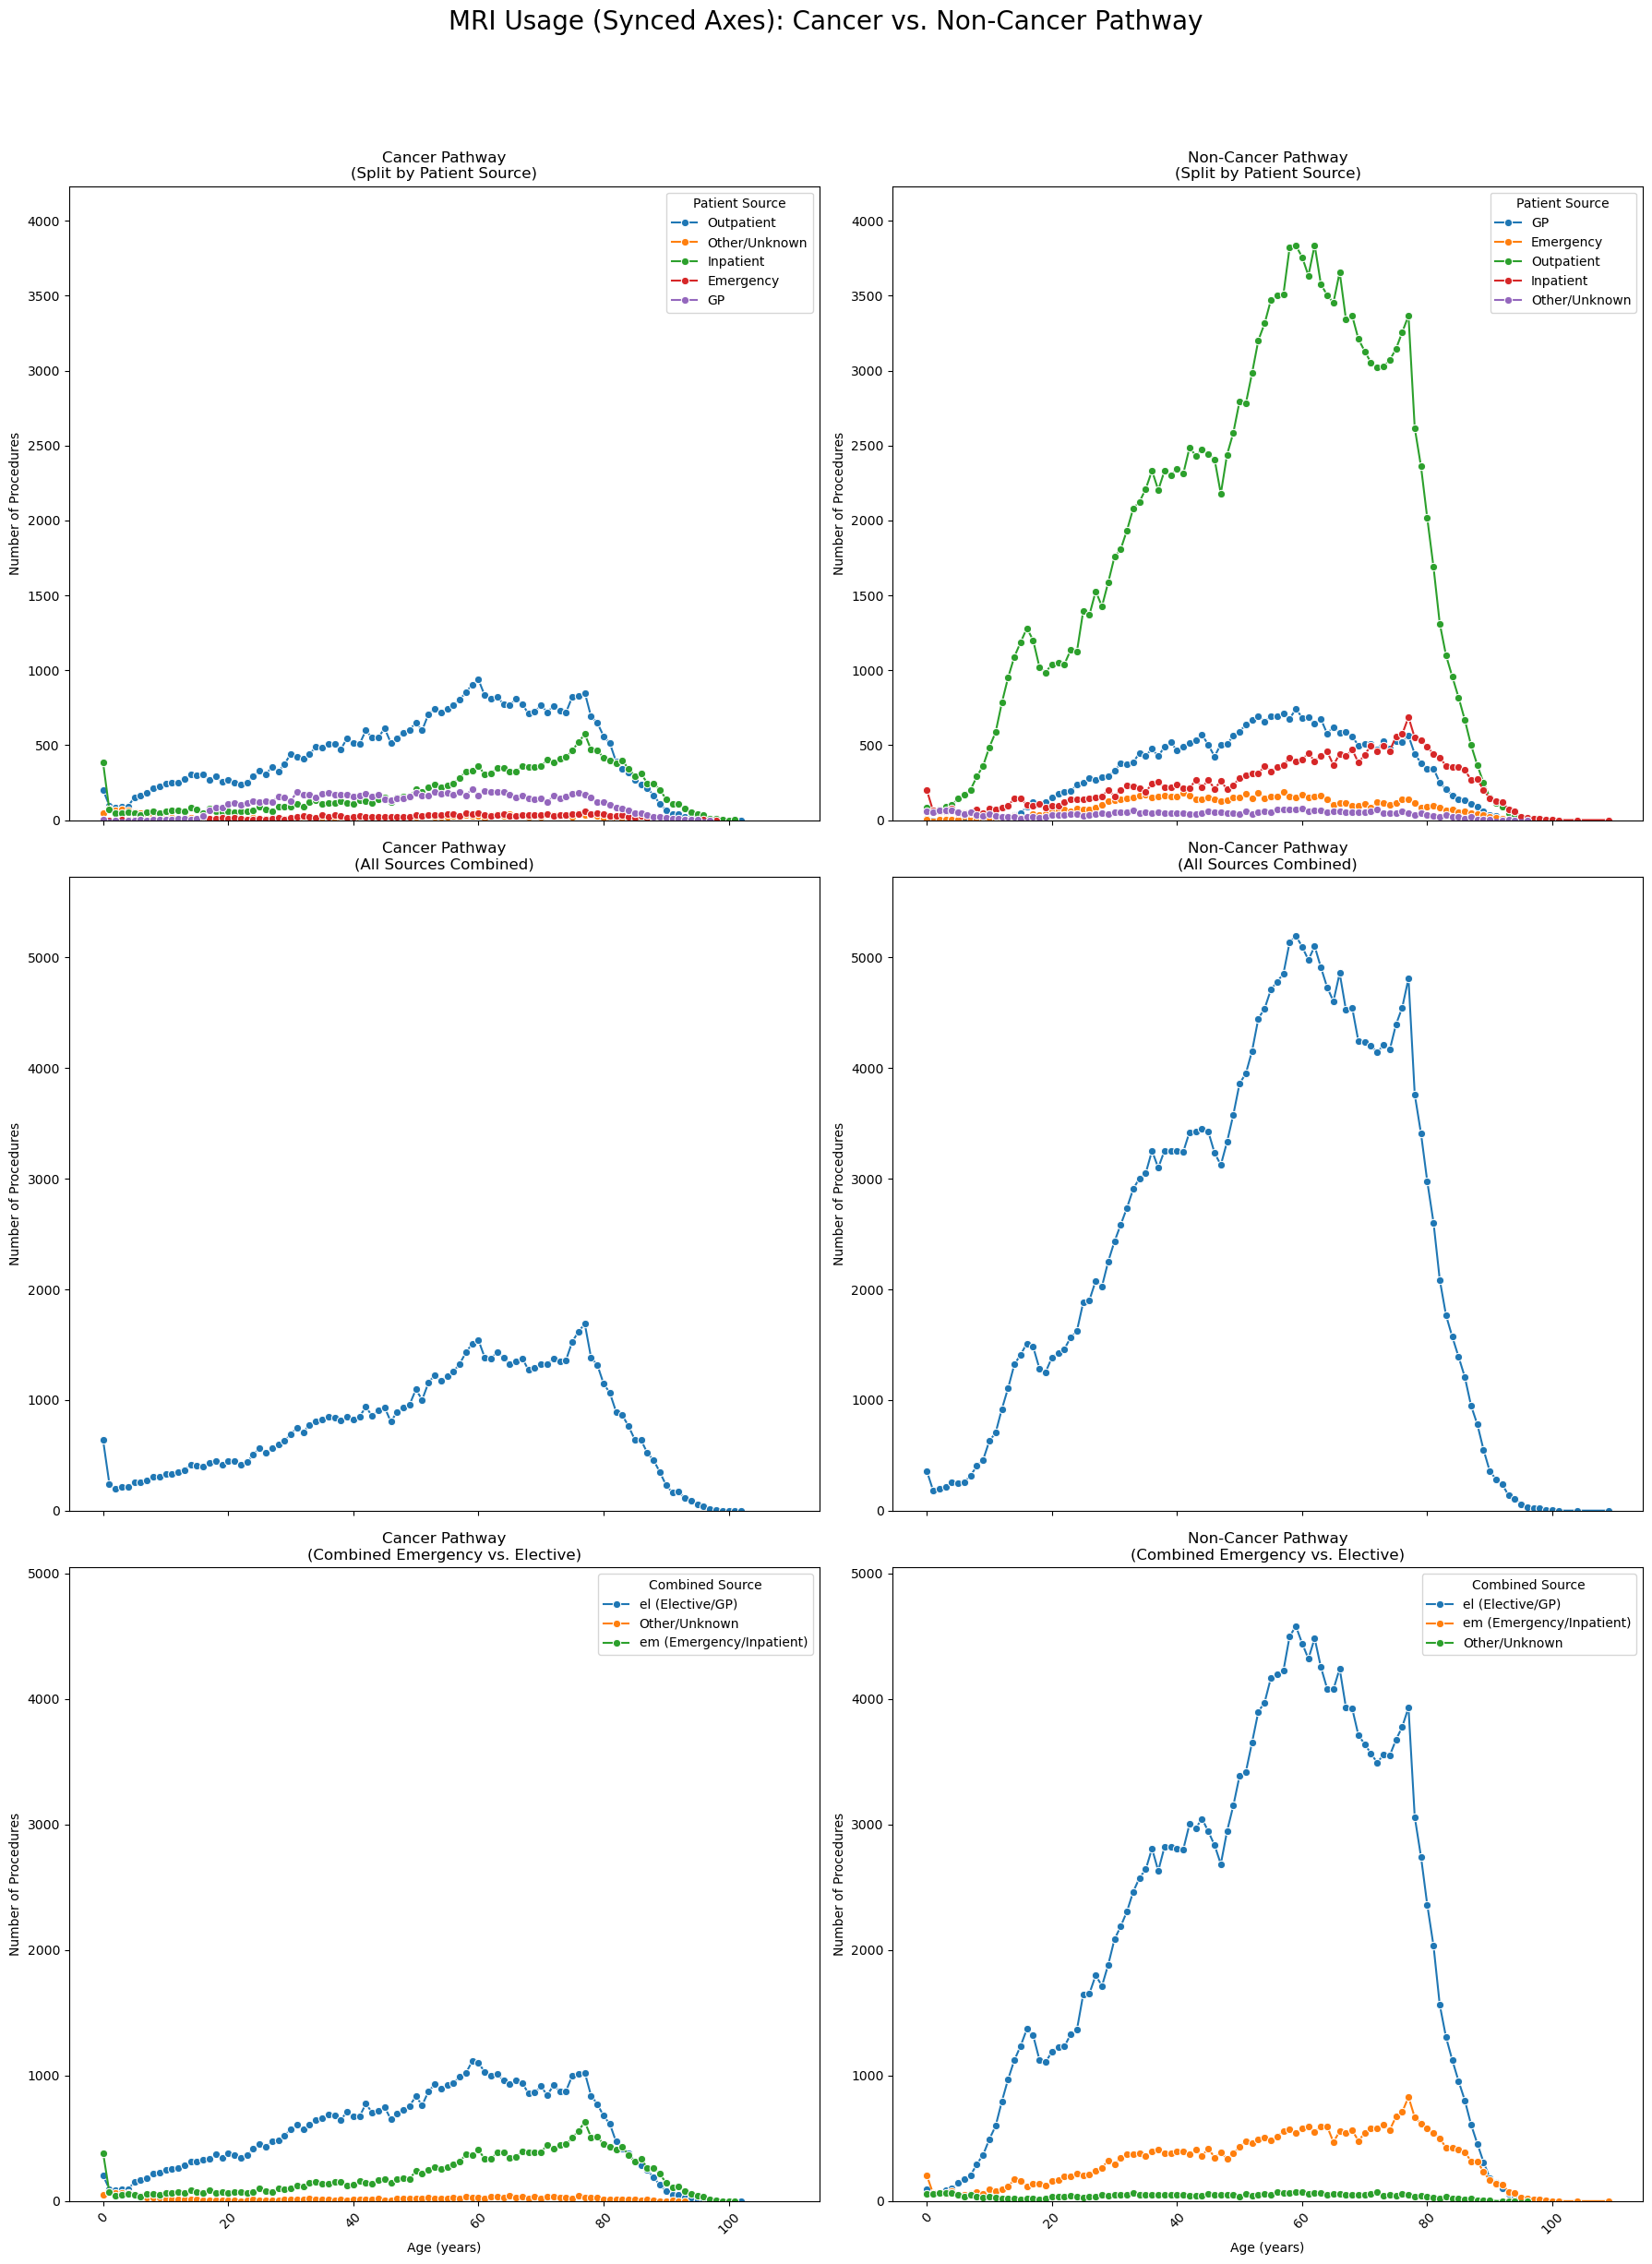

--- Generating SYNCED Comparison Plots for Endoscopy ---


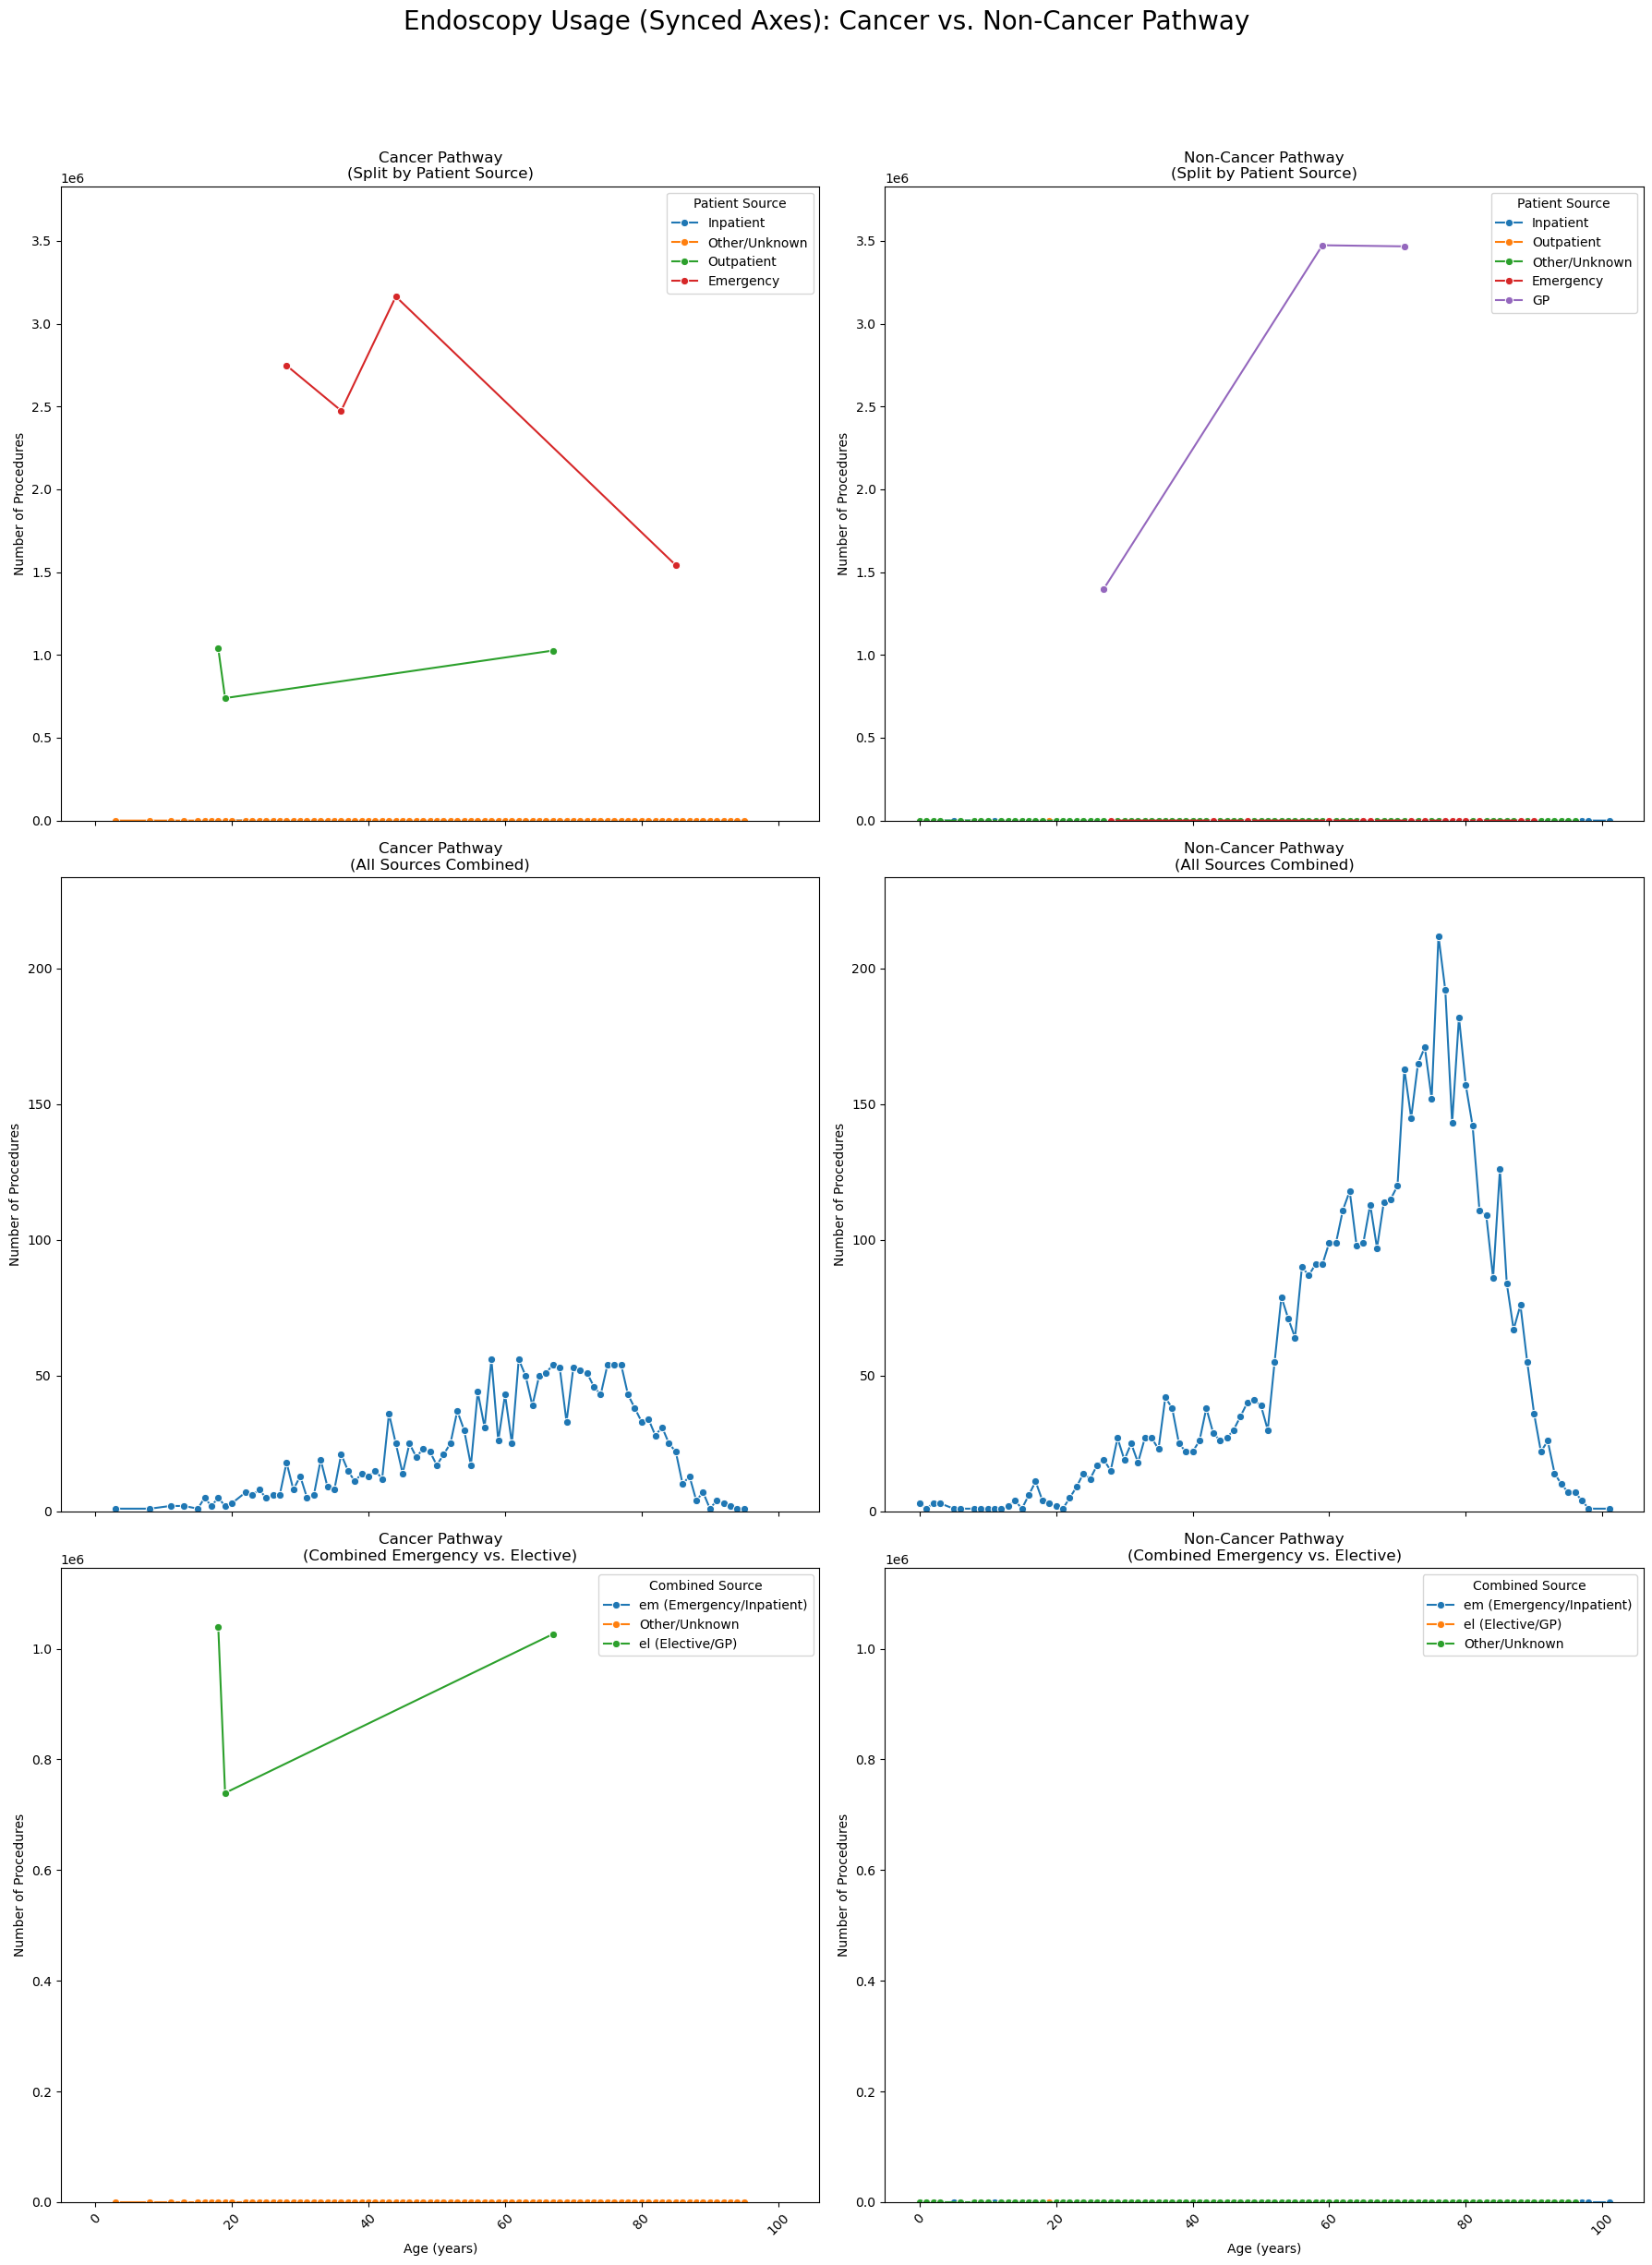

In [7]:
# --- Run the new function for synced plots ---
if 'df' in locals() and not df.empty:
    modality_buckets_to_plot = ['CT', 'MRI', 'Endoscopy']
    available_buckets = df['modality_bucket'].unique()
    
    for bucket in modality_buckets_to_plot:
        if bucket in available_buckets:
            plot_usage_by_cancer_status_synced(df, bucket)
        else:
            print(f"Modality bucket '{bucket}' not found in the dataset.")
else:
    print("DataFrame 'df' is not available or is empty. Cannot generate plots.")

In [8]:
# =========================================================================
#  ==> FINAL STEP (ADJUSTED): Create Pivoted Summary Table for Report <==
# =========================================================================

if 'df' in locals() and not df.empty:
    print("--- Generating Pivoted Summary Statistics Table ---")
    
    # Define the core modalities of interest
    modalities_of_interest = ['CT', 'MRI', 'Endoscopy']
    
    # Filter the DataFrame to only include the core modalities for the summary
    summary_df = df[df['modality_bucket'].isin(modalities_of_interest)].copy()

    # Create the pivot table with the desired structure
    # Index: Age Bands
    # Columns: Modality, then split by Cancer Status
    # Values: Count of procedures
    pivoted_table = pd.pivot_table(
        summary_df,
        index='age_at_event',
        columns=['modality_bucket', 'cancer_status'],
        aggfunc='size',  # 'size' is an efficient way to count rows
        fill_value=0     # Replace any missing combinations with 0
    )

    # Reorder the columns to ensure a logical layout if needed (CT, MRI, Endoscopy)
    # The order is defined by the 'modalities_of_interest' list
    pivoted_table = pivoted_table.reindex(columns=modalities_of_interest, level=0)
    
    # Add a 'Total' column for each modality
    for mod in modalities_of_interest:
        if mod in pivoted_table.columns.get_level_values(0):
             pivoted_table[(mod, 'Total')] = pivoted_table[mod].sum(axis=1)

    # Sort the column levels for a clean final presentation
    pivoted_table.sort_index(axis=1, inplace=True)


    # Display the final pivoted table
    display(pivoted_table.style.set_caption("Procedure Count by Age Band, Modality, and Cancer Status").format('{:,.0f}'))

else:
    print("DataFrame 'df' not found or is empty. Cannot generate summary table.")

--- Generating Pivoted Summary Statistics Table ---


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_12385/697902741.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_table = pd.pivot_table(
